### ARMA(1,1) with parameters estimated using the Metropolis Hastings Algorithm  (Pymc package) 

#### Four companies listed on the JSE     
                                      : Netcare group limited
                                      : Sanlam limited
                                      : Nedbank group
                                      : Sanlam limited

#### Netcare group limited

In [2]:
#importing the modules in python
from pandas_datareader import data as web
import matplotlib.pylab as plt
import matplotlib.dates as dates
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
%matplotlib inline
import warnings

#load the data 
filename = 'ntc.csv'
netcareTS = pd.read_csv(filename,na_filter=True,index_col="Date").dropna()
netcareTS.head(5)



,Open,High,Low,Close,Volume
Date,,,,,
13/01/02,1985,1990,1963,1975.0,514952
13/01/03,1974,1976,1960,1970.0,584990
13/01/04,1969,2011,1954,2000.0,3130465
13/01/07,2005,2010,1977,1990.0,1483949
13/01/08,2000,2000,1986,2000.0,1269313


$\textbf{Plot the closing prices}$

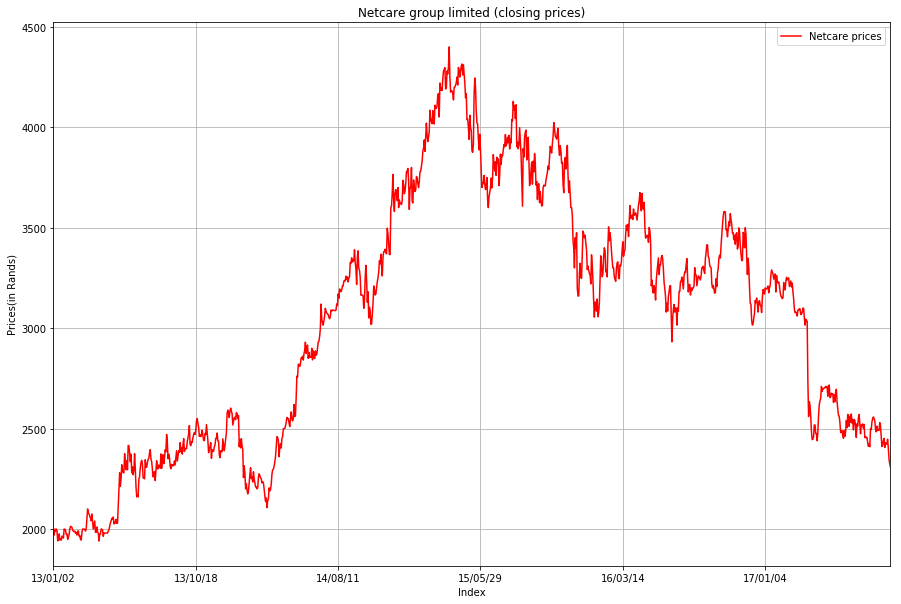

In [9]:
plt.figure(figsize=(15,10))
netcareTS["Close"].plot(label="Netcare prices",color="red")
plt.grid(True)
plt.title("Netcare group limited (closing prices)",color="black")
plt.xlabel("Index")
plt.ylabel("Prices(in Rands)")
plt.legend(loc=1)

$\textbf{The log-returns}$: 


To analyze the stock price, we usually calculate the logged return of
the stock to make the data stationary. The log returns are calculated using
$r_{t}=log\Big(\frac{p_{t}}{p_{t-1}}\Big)$, where $p_{t}$ is the closing price at time $t$

In [10]:
returns=np.log((netcareTS["Close"])/(netcareTS["Close"].shift()))
returns.head(5)
returns=returns.dropna()

#### $\textbf{Split the data into multiple training and testing sets}$

                                    split1: Train:500  Test: 200
                                    split2: Train:700  Test: 200
                                    

#### Split1: Train 500  Test:200

In [11]:
netcareTrain1=returns[0:500]
netcareTest1=returns[500:700]

The following plot shows the daily logged return of Netcare group limited


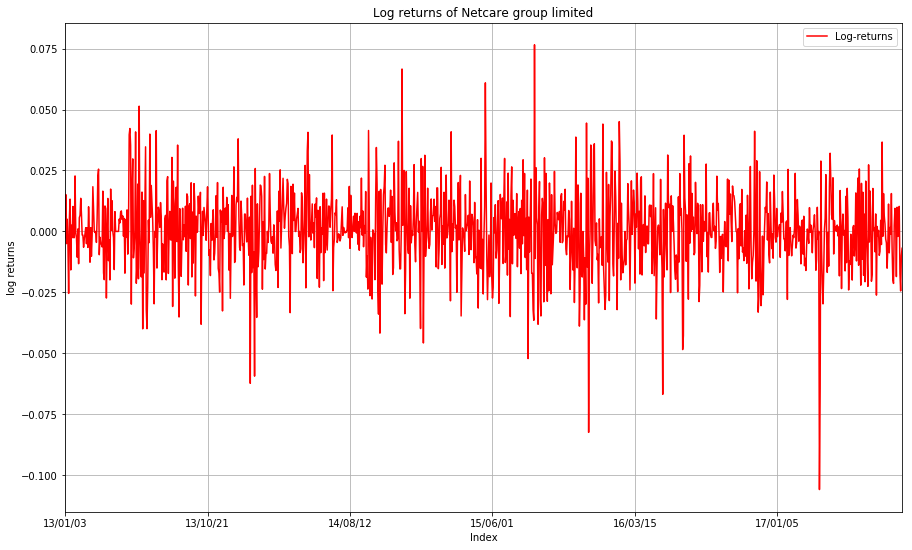

In [12]:
print("The following plot shows the daily logged return of Netcare group limited")
plt.figure(figsize=(15,9))
returns.plot(label="Log-returns",color="red")
plt.grid(True)
plt.title("Log returns of Netcare group limited",color="black")
plt.xlabel("Index")
plt.ylabel("log returns")
plt.legend(loc=0)
plt.show()

#### ARMA11 model-Metropolis hastings algorithmn

In [13]:
import statsmodels.tsa.api as smt
import pymc as mc
np.random.seed(123)
# Priors
prior_phi = mc.Uniform('phi', -1, 1)
prior_theta = mc.Uniform('theta', -1, 1)
prior_precision = mc.Gamma('precision', 2, 4)

# Create the model for likelihood evaluation
model = smt.SARIMAX(netcareTrain1,order=(1, 0, 1))

# Create the "data" component (stochastic and observed)
@mc.stochastic(dtype=smt.statespace.MLEModel, observed=True)
def loglikelihood(value=model, phi=prior_phi,theta=prior_theta, precision=prior_precision):
    return value.loglike([phi, theta, 1/precision])

# Create the PyMC model
pymc_model = mc.Model((prior_phi,prior_theta, prior_precision, loglikelihood))

# Create a PyMC sample and perform sampling
sampler = mc.MCMC(pymc_model)
sampler.sample(iter=20000, burn=3000, thin=10)

/home/vhahangwele/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


 [-----------------100%-----------------] 20000 of 20000 complete in 102.9 sec

Plotting theta
Plotting precision
Plotting phi


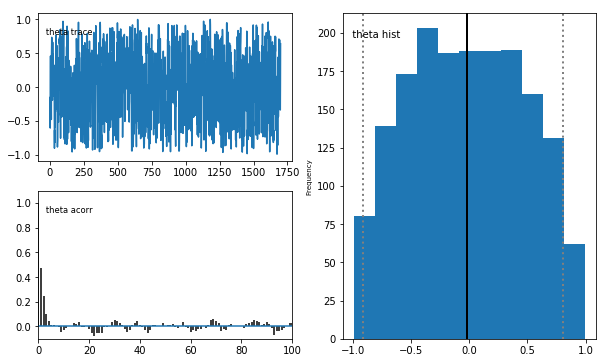

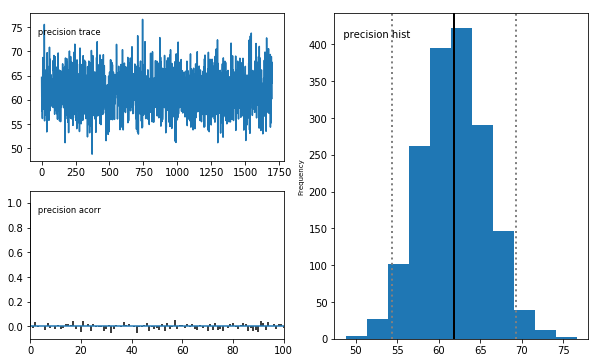

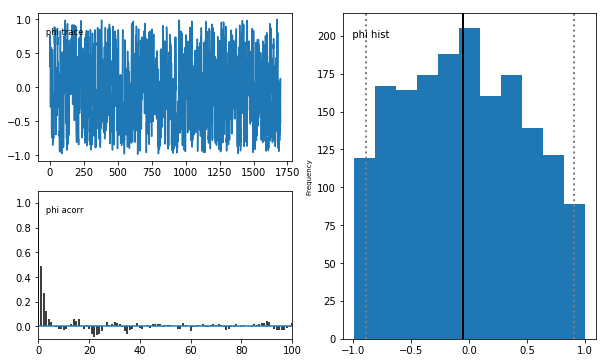

The chains seems to have converge to the posterior distributions for all the paramters, we can see that the chains fluctuate within a common stable mean value. Since a Markov chain is a sequence of random numbers such that each number is dependent upon previous number, this result in autocorrelations in the cahins. So, we thin the chains to reduce the autocrrelations 


In [14]:
# Plot traces for the individual parameters
warnings.filterwarnings("ignore") 
mc.Matplot.plot(sampler)
plt.show()
print("The chains seems to have converge to the posterior distributions for all the paramters, we can see that the chains fluctuate within a common stable mean value. Since a Markov chain is a sequence of random numbers such that each number is dependent upon previous number, this result in autocorrelations in the cahins. So, we thin the chains to reduce the autocrrelations ")

In [15]:
#Exploring model parameters
print'In bayesian  methods, the (Mean)expected value is used to give the best estimator of \
parameter. MC Error is the monte carlo error(it indicates the amount of error in the \
estimates as a result of using the MCMC ) values closer to 0 indicates a small error.\
95% Highest Posterior Density (HPD) interval-Note that the estimate of the mean lies within \
the 95% HPD interval. A special type of Bayesian interval is the highest posterior density \
(HPD) interval. It is built so as to include the values of θ that have the highest posterior\
probability (the most likely values)'

sampler.summary()

In bayesian  methods, the (Mean)expected value is used to give the best estimator of parameter. MC Error is the monte carlo error(it indicates the amount of error in the estimates as a result of using the MCMC ) values closer to 0 indicates a small error.95% Highest Posterior Density (HPD) interval-Note that the estimate of the mean lies within the 95% HPD interval. A special type of Bayesian interval is the highest posterior density (HPD) interval. It is built so as to include the values of θ that have the highest posteriorprobability (the most likely values)

theta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.018           0.492            0.02             [-0.912  0.803]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.879           -0.42           -0.024         0.378

In [16]:
#make predictions from the fitted modeL
#We use the retrieved coefficients from the fitted model to make predictions
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as smt
from math import sqrt
netcareTrain1=np.array(netcareTrain1)   
netcareTest1=np.array(netcareTest1) 
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat
import numpy as np
ar_params=prior_phi.stats()['mean']
ar_params=np.array([ar_params])
ma_params=prior_theta.stats()['mean']
ma_params=np.array([ma_params]) 
history = [x for x in netcareTrain1]
test_predicted = list()
for t in range(len(netcareTest1)):
    model_fit = model.fit(trend='nc', disp=False)
    ar_coef, ma_coef = ar_params, ma_params
    resid = model_fit.resid
    yhat = predict(ar_coef, history) + predict(ma_coef, resid)
    test_predicted.append(yhat)
    obs = netcareTest1[t]
    history.append(obs)
    print('predicted=%.5f, expected=%.5f' % (yhat, obs))
    

predicted=0.00234, expected=0.02990
predicted=-0.00048, expected=0.00000
predicted=0.00073, expected=0.02667
predicted=-0.00035, expected=-0.04577
predicted=0.00258, expected=-0.00193
predicted=0.00081, expected=0.03125
predicted=-0.00053, expected=-0.01022
predicted=0.00114, expected=-0.00542
predicted=0.00095, expected=0.00244
predicted=0.00063, expected=0.01773
predicted=0.00001, expected=-0.00240
predicted=0.00083, expected=-0.00696
predicted=0.00101, expected=-0.00539
predicted=0.00095, expected=0.00781
predicted=0.00041, expected=0.01332
predicted=0.00019, expected=0.00053
predicted=0.00071, expected=0.00633
predicted=0.00047, expected=0.00655
predicted=0.00047, expected=0.01323
predicted=0.00020, expected=0.00411
predicted=0.00056, expected=0.01021
predicted=0.00032, expected=-0.01458
predicted=0.00132, expected=0.01788
predicted=0.00001, expected=0.01782
predicted=0.00001, expected=-0.01529
predicted=0.00135, expected=-0.00786
predicted=0.00105, expected=0.00533
predicted=0.000

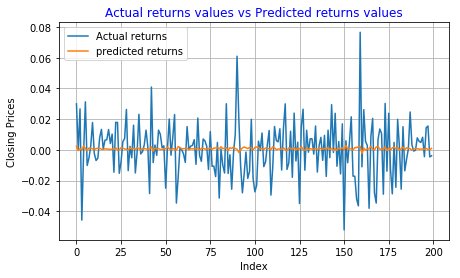

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(netcareTest1,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()


In [18]:
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(netcareTest1)):
    if netcareTest1[t-1]>=netcareTest1[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)

([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1], 200)
Predicted data:
([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,

(200, 200, list)

In [19]:
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
print("From a sample of",len(binary_test),"data points")

('The number of correct direction predictions is:', 137, 'out of:', 200, 'data points')
('From a sample of', 200, 'data points')


Accuracy for testing data:
(68.5, '%')
[[68 26]
 [37 69]]


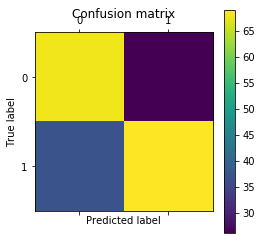

In [20]:
#function to compute the confusion matrix
#accuracy decsribes: overall, how often the classifier is correct
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print("Accuracy for testing data:")
def Confusion_matrix(n):
    print(accuracy_score(binary_test[0:n],binary_predicted_test[0:n])*100,"%")
    confusion=confusion_matrix(binary_test[0:n],binary_predicted_test[0:n])
    print(confusion) 
    #show confusion matrix
    plt.matshow(confusion)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
Confusion_matrix(len(binary_test))

#### split2: Train 700  Test:200

In [21]:
netcareTrain1=returns[0:700]
netcareTest1=returns[700:900]

In [22]:
import statsmodels.tsa.api as smt
import pymc as mc
np.random.seed(123)
# Priors
prior_phi = mc.Uniform('phi', -1, 1)
prior_theta = mc.Uniform('theta', -1, 1)
prior_precision = mc.Gamma('precision', 2, 4)

# Create the model for likelihood evaluation
model = smt.SARIMAX(netcareTrain1, order=(1, 0, 1))

# Create the "data" component (stochastic and observed)
@mc.stochastic(dtype=smt.statespace.MLEModel, observed=True)
def loglikelihood(value=model, phi=prior_phi,theta=prior_theta, precision=prior_precision):
    return value.loglike([phi, theta, 1/precision])

# Create the PyMC model
pymc_model = mc.Model((prior_phi,prior_theta, prior_precision, loglikelihood))

# Create a PyMC sample and perform sampling
sampler = mc.MCMC(pymc_model)
sampler.sample(iter=20000, burn=3000, thin=10)


 [-----------------100%-----------------] 20000 of 20000 complete in 126.1 sec

Plotting precision
Plotting phi
Plotting theta


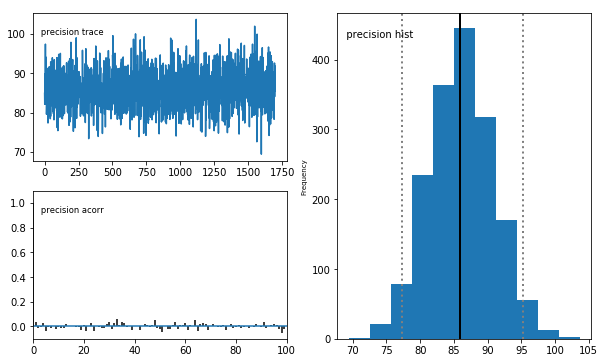

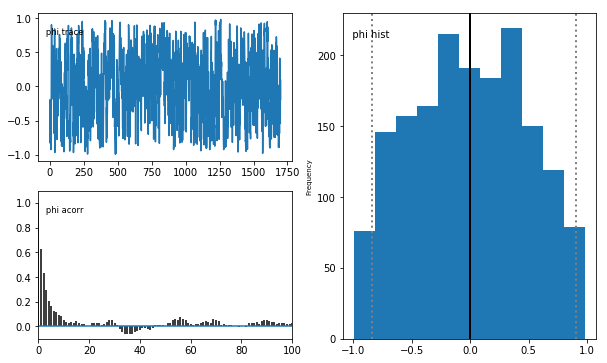

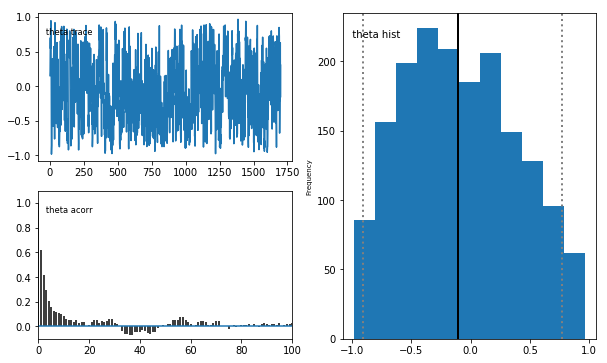

The chains seems to have converge to the posterior distributions for all the paramters, we can see that the chains fluctuate within a common stable mean value. Since a Markov chain is a sequence of random numbers such that each number is dependent upon previous number, this result in autocorrelations in the cahins. So, we thin the chains to reduce the autocrrelations 

precision:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	86.037           4.708            0.097          [ 77.34   95.272]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	77.256           82.6            85.976         89.226        95.238
	

phi:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.008           0.493       

In [23]:
# Plot traces for the individual parameters
warnings.filterwarnings("ignore") 
mc.Matplot.plot(sampler)
plt.show()
print("The chains seems to have converge to the posterior distributions for all the paramters, we can see that the chains fluctuate within a common stable mean value. Since a Markov chain is a sequence of random numbers such that each number is dependent upon previous number, this result in autocorrelations in the cahins. So, we thin the chains to reduce the autocrrelations ")
sampler.summary()

In [24]:
#make predictions from the fitted modeL
#We use the retrieved coefficients from the fitted model to make predictions
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as smt
from math import sqrt
netcareTrain1=np.array(netcareTrain1)   
netcareTest1=np.array(netcareTest1) 
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat
import numpy as np
ar_params=prior_phi.stats()['mean']
ar_params=np.array([ar_params])
ma_params=prior_theta.stats()['mean']
ma_params=np.array([ma_params]) 
history = [x for x in netcareTrain1]
test_predicted = list()
for t in range(len(netcareTest1)):
    model_fit = model.fit(trend='nc', disp=False)
    ar_coef, ma_coef = ar_params, ma_params
    resid = model_fit.resid
    yhat = predict(ar_coef, history) + predict(ma_coef, resid)
    test_predicted.append(yhat)
    obs = netcareTest1[t]
    history.append(obs)
    print('predicted=%.5f, expected=%.5f' % (yhat, obs))
    

predicted=0.00026, expected=0.01232
predicted=0.00013, expected=0.00889
predicted=0.00016, expected=0.01730
predicted=0.00009, expected=-0.00723
predicted=0.00028, expected=-0.00956
predicted=0.00030, expected=-0.00177
predicted=0.00024, expected=-0.00228
predicted=0.00024, expected=0.00859
predicted=0.00016, expected=0.00502
predicted=0.00019, expected=-0.02381
predicted=0.00041, expected=-0.01031
predicted=0.00031, expected=0.01236
predicted=0.00013, expected=-0.00693
predicted=0.00028, expected=-0.01584
predicted=0.00035, expected=0.00131
predicted=0.00022, expected=-0.02917
predicted=0.00045, expected=-0.01137
predicted=0.00031, expected=0.03871
predicted=-0.00008, expected=0.00782
predicted=0.00016, expected=-0.01492
predicted=0.00034, expected=0.01907
predicted=0.00008, expected=0.01158
predicted=0.00013, expected=-0.03885
predicted=0.00053, expected=-0.02313
predicted=0.00041, expected=0.01566
predicted=0.00010, expected=-0.01757
predicted=0.00036, expected=-0.01871
predicted=0.

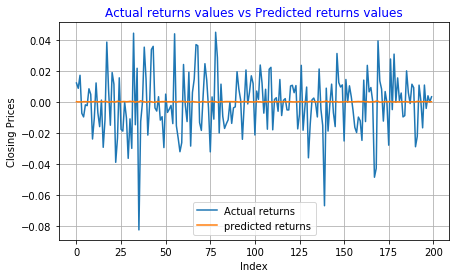

([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1], 200)
Predicted data:
([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,

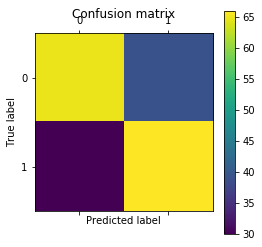

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(netcareTest1,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))
print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(netcareTest1)):
    if netcareTest1[t-1]>=netcareTest1[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)

#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
print("From a sample of",len(binary_test),"data points")
Confusion_matrix(len(binary_test))

$\textbf{Santam Ltd}$

Santam Ltd is an insurer covering general insurance and investment operations, as well as investments in emerging market insurance companies. The Company's segments include insurance, which includes core general insurance and reinsurance underwriting activities undertaken by the Company and are analyzed by insurance class; Investment, which includes all investment-related activities undertaken by the Company, and Strategic diversification, which relate to all strategic investing activities where the purpose of the activities is to obtain certain diversification benefits. The Company's business units include Santam Commercial and Personal, which offers business portfolio, multiproduct and multichannel distribution portfolio, and independent administration capability; Santam Specialist, which focuses on the insurance of risks in various market segments; MiWay, which is a direct insurer in the group, and Santam re, which is a wholesale reinsurance service provider

In [26]:
#load the data 
filename = 'snt.csv'
santamTS = pd.read_csv(filename,na_filter=True,index_col="Date").dropna()
santamTS.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
13/01/02,18950,19321,18950,18990.0,29044
13/01/03,19000,19001,18979,18990.0,7150
13/01/04,19000,19000,18482,18597.0,14707
13/01/07,19000,19000,18654,18850.0,7530
13/01/08,19000,19000,18736,19000.0,8986


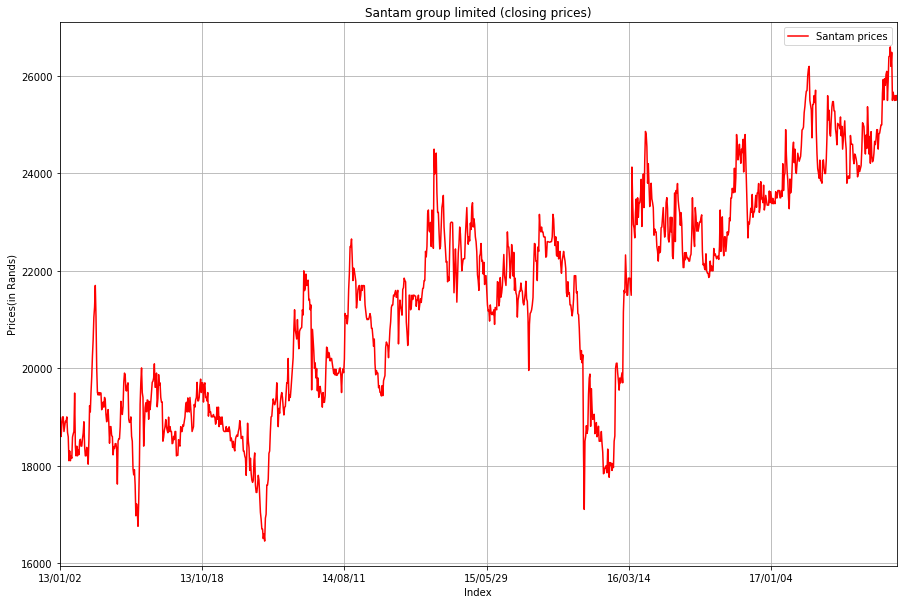

In [27]:
plt.figure(figsize=(15,10))
santamTS["Close"].plot(label="Santam prices",color="red")
plt.grid(True)
plt.title("Santam group limited (closing prices)",color="black")
plt.xlabel("Index")
plt.ylabel("Prices(in Rands)")
plt.legend(loc=1)

In [28]:
#The log-returns
returns=np.log((santamTS["Close"])/(santamTS["Close"].shift()))
returns.head(5)
returns=returns.dropna()

### split1 Train: 500 Test :200

In [29]:
Santam_Train=returns[0:500]
Santam_Test=returns[500:700]

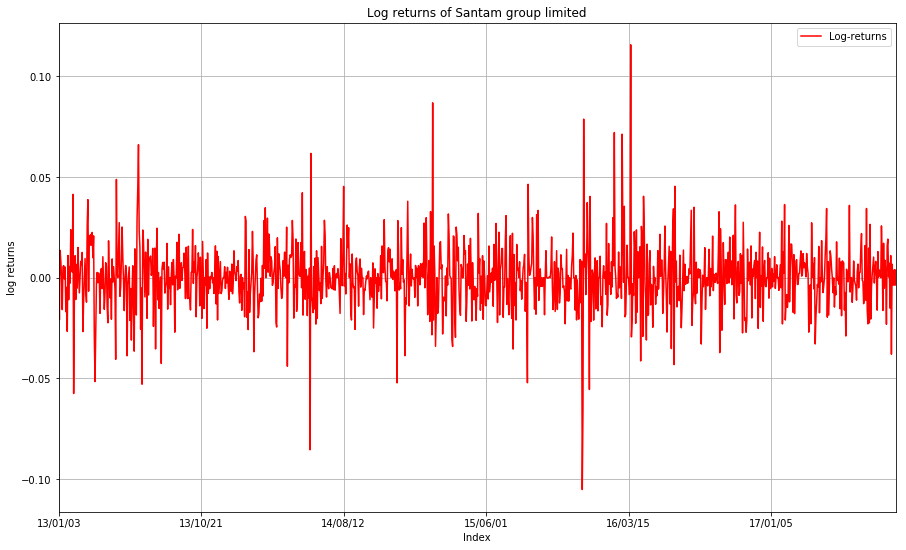

In [30]:
plt.figure(figsize=(15,9))
returns.plot(label="Log-returns",color="red")
plt.grid(True)
plt.title("Log returns of Santam group limited",color="black")
plt.xlabel("Index")
plt.ylabel("log returns")
plt.legend(loc=0)
plt.show()

In [31]:
import statsmodels.tsa.api as smt
import pymc as mc
np.random.seed(123)
# Priors
prior_phi = mc.Uniform('phi', -1, 1)
prior_theta = mc.Uniform('theta', -1, 1)
prior_precision = mc.Gamma('precision', 2, 4)

# Create the model for likelihood evaluation
model = smt.SARIMAX(Santam_Train, order=(1, 0, 1))

# Create the "data" component (stochastic and observed)
@mc.stochastic(dtype=smt.statespace.MLEModel, observed=True)
def loglikelihood(value=model, phi=prior_phi, theta=prior_theta, precision=prior_precision):
    return value.loglike([phi, theta, 1/precision])

# Create the PyMC model
pymc_model = mc.Model((prior_phi, prior_theta, prior_precision, loglikelihood))

# Create a PyMC sample and perform sampling
sampler = mc.MCMC(pymc_model)
sampler.sample(iter=20000, burn=3000, thin=10)

 [-----------------100%-----------------] 20000 of 20000 complete in 80.0 sec

Plotting phi
Plotting theta
Plotting precision


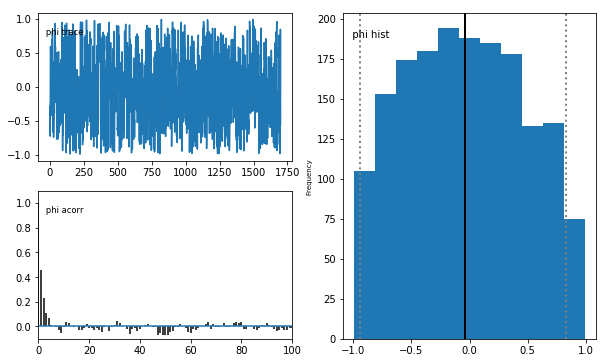

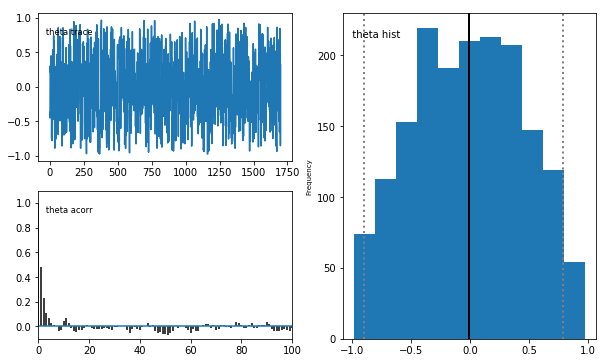

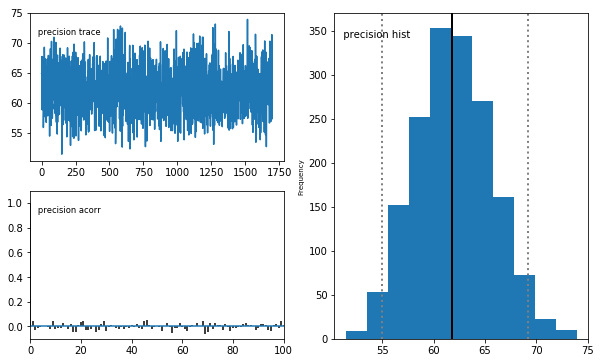

The chains seems to have converge to the posterior distributions for all the paramters, we can see that the chains fluctuate within a common stable mean value. Since a Markov chain is a sequence of random numbers such that each number is dependent upon previous number, this result in autocorrelations in the cahins. So, we thin the chains to reduce the autocrrelations 


In [32]:
# Plot traces for the individual parameters
warnings.filterwarnings("ignore") 
mc.Matplot.plot(sampler)
plt.show()
print("The chains seems to have converge to the posterior distributions for all the paramters, we can see that the chains fluctuate within a common stable mean value. Since a Markov chain is a sequence of random numbers such that each number is dependent upon previous number, this result in autocorrelations in the cahins. So, we thin the chains to reduce the autocrrelations ")

In [33]:
print'In bayesian  methods, the (Mean)expected value is used to give the best estimator of \
parameter. MC Error is the monte carlo error(it indicates the amount of error in the \
estimates as a result of using the MCMC ) values closer to 0 indicates a small error.\
95% Highest Posterior Density (HPD) interval-Note that the estimate of the mean lies within \
the 95% HPD interval. A special type of Bayesian interval is the highest posterior density \
(HPD) interval. It is built so as to include the values of θ that have the highest posterior\
probability (the most likely values)'

sampler.summary()

In bayesian  methods, the (Mean)expected value is used to give the best estimator of parameter. MC Error is the monte carlo error(it indicates the amount of error in the estimates as a result of using the MCMC ) values closer to 0 indicates a small error.95% Highest Posterior Density (HPD) interval-Note that the estimate of the mean lies within the 95% HPD interval. A special type of Bayesian interval is the highest posterior density (HPD) interval. It is built so as to include the values of θ that have the highest posteriorprobability (the most likely values)

phi:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.039           0.509            0.021            [-0.946  0.833]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.909           -0.457          -0.042         0.361  

In [34]:
#make predictions from the fitted modeL
#We use the retrieved coefficients from the fitted model to make predictions
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as smt
from math import sqrt
Santam_Train=np.array(Santam_Train)   
Santam_Test=np.array(Santam_Test) 
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat
import numpy as np
ar_params=prior_phi.stats()['mean']
ar_params=np.array([ar_params])
ma_params=prior_theta.stats()['mean']
ma_params=np.array([ma_params]) 
history = [x for x in Santam_Train]
test_predicted = list()
for t in range(len(Santam_Test)):
    model_fit = model.fit(trend='nc', disp=False)
    ar_coef, ma_coef = ar_params, ma_params
    resid = model_fit.resid
    yhat = predict(ar_coef, history) + predict(ma_coef, resid)
    test_predicted.append(yhat)
    obs = Santam_Test[t]
    history.append(obs)
    print('predicted=%.5f, expected=%.5f' % (yhat, obs))
    

predicted=0.00001, expected=-0.00978
predicted=0.00038, expected=0.00605
predicted=-0.00023, expected=0.00000
predicted=0.00000, expected=0.00466
predicted=-0.00018, expected=-0.01405
predicted=0.00054, expected=0.00597
predicted=-0.00023, expected=0.00472
predicted=-0.00018, expected=-0.00360
predicted=0.00014, expected=0.00695
predicted=-0.00027, expected=0.00640
predicted=-0.00024, expected=0.00032
predicted=-0.00001, expected=0.00714
predicted=-0.00027, expected=0.00005
predicted=0.00000, expected=0.02711
predicted=-0.00104, expected=-0.00506
predicted=0.00020, expected=0.00951
predicted=-0.00037, expected=0.02977
predicted=-0.00115, expected=0.00302
predicted=-0.00011, expected=-0.01845
predicted=0.00071, expected=-0.00110
predicted=0.00004, expected=0.00852
predicted=-0.00033, expected=-0.02176
predicted=0.00084, expected=0.03279
predicted=-0.00126, expected=-0.00595
predicted=0.00023, expected=-0.02844
predicted=0.00110, expected=0.08676
predicted=-0.00335, expected=-0.02108
pre

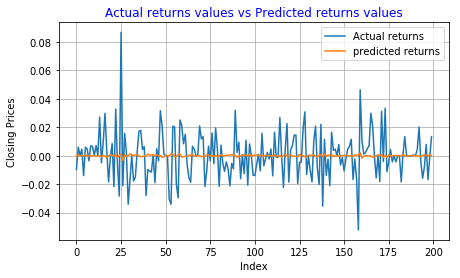

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(Santam_Test,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()

In [36]:
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(Santam_Test)):
    if Santam_Test[t-1]>=Santam_Test[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)

([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0], 200)
Predicted data:
([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,

(200, 200, list)

In [37]:
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
print("From a sample of",len(binary_test),"data points")

('The number of correct direction predictions is:', 138, 'out of:', 200, 'data points')
('From a sample of', 200, 'data points')


(69.0, '%')
[[69 32]
 [30 69]]


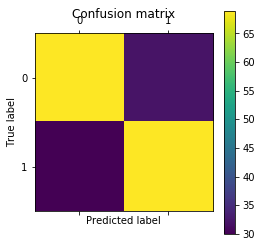

In [38]:
Confusion_matrix(len(Santam_Test))

### split2 Train: 700 Test :200

In [39]:
Santam_Train=returns[0:700]
Santam_Test=returns[700:900]

In [40]:
import statsmodels.tsa.api as smt
import pymc as mc

# Priors
prior_phi = mc.Uniform('phi', -1, 1)
prior_theta = mc.Uniform('theta', -1, 1)
prior_precision = mc.Gamma('precision', 2, 4)

# Create the model for likelihood evaluation
model = smt.SARIMAX(Santam_Train, order=(1, 0, 1))

# Create the "data" component (stochastic and observed)
@mc.stochastic(dtype=smt.statespace.MLEModel, observed=True)
def loglikelihood(value=model, phi=prior_phi, theta=prior_theta, precision=prior_precision):
    return value.loglike([phi, theta, 1/precision])

# Create the PyMC model
pymc_model = mc.Model((prior_phi, prior_theta, prior_precision, loglikelihood))

# Create a PyMC sample and perform sampling
sampler = mc.MCMC(pymc_model)
sampler.sample(iter=20000, burn=3000, thin=10)

 [-----------------100%-----------------] 20000 of 20000 complete in 83.4 sec

Plotting theta
Plotting phi
Plotting precision


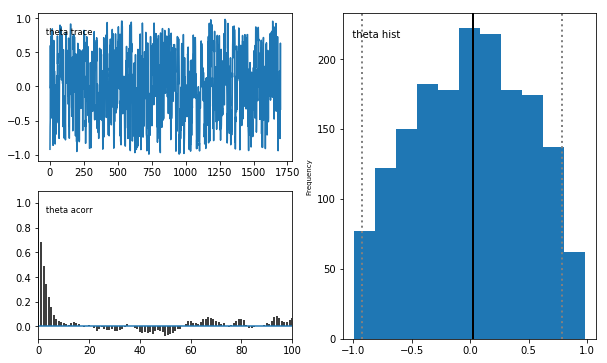

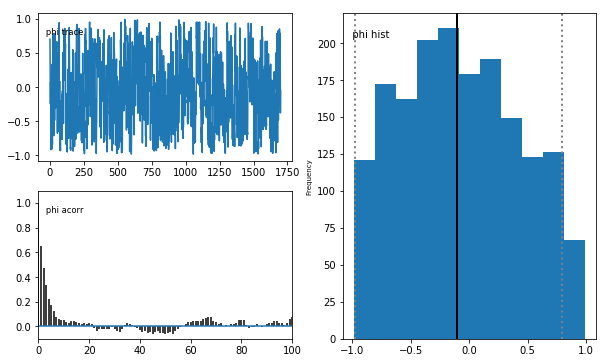

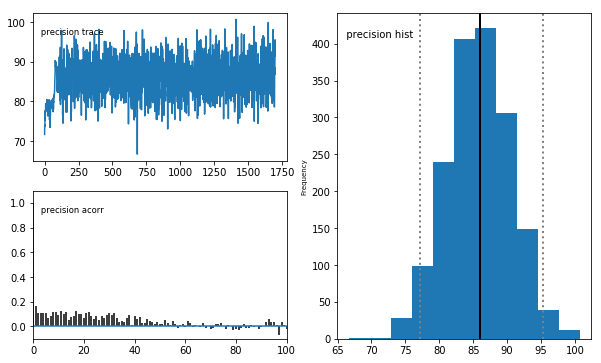


theta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.007            0.483            0.026            [-0.928  0.787]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.895           -0.363          0.025          0.387         0.863
	

phi:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.069           0.505            0.027            [-0.972  0.793]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.913           -0.469          -0.099         0.317         0.866
	

precision:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [41]:
# Plot traces for the individual parameters
warnings.filterwarnings("ignore") 
mc.Matplot.plot(sampler)
plt.show()
sampler.summary()

In [42]:
#make predictions from the fitted modeL
#We use the retrieved coefficients from the fitted model to make predictions
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as smt
from math import sqrt
Santam_Train=np.array(Santam_Train)   
Santam_Test=np.array(Santam_Test) 
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat
import numpy as np
ar_params=prior_phi.stats()['mean']
ar_params=np.array([ar_params])
ma_params=prior_theta.stats()['mean']
ma_params=np.array([ma_params]) 
history = [x for x in Santam_Train]
test_predicted = list()
for t in range(len(Santam_Test)):
    model_fit = model.fit(trend='nc', disp=False)
    ar_coef, ma_coef = ar_params, ma_params
    resid = model_fit.resid
    yhat = predict(ar_coef, history) + predict(ma_coef, resid)
    test_predicted.append(yhat)
    obs = Santam_Test[t]
    history.append(obs)
    print('predicted=%.5f, expected=%.5f' % (yhat, obs))

predicted=-0.00083, expected=-0.01583
predicted=0.00118, expected=0.00471
predicted=-0.00023, expected=0.00223
predicted=-0.00006, expected=-0.01258
predicted=0.00095, expected=-0.00772
predicted=0.00062, expected=0.01133
predicted=-0.00069, expected=0.00449
predicted=-0.00022, expected=0.00447
predicted=-0.00022, expected=-0.00492
predicted=0.00043, expected=-0.00405
predicted=0.00037, expected=-0.00678
predicted=0.00056, expected=-0.02294
predicted=0.00167, expected=-0.00363
predicted=0.00034, expected=0.01406
predicted=-0.00088, expected=-0.01155
predicted=0.00088, expected=0.00111
predicted=0.00001, expected=-0.01167
predicted=0.00089, expected=0.00000
predicted=0.00009, expected=-0.00494
predicted=0.00043, expected=-0.00568
predicted=0.00048, expected=0.00539
predicted=-0.00028, expected=0.01089
predicted=-0.00066, expected=0.02211
predicted=-0.00143, expected=0.00000
predicted=0.00009, expected=0.00000
predicted=0.00009, expected=-0.01611
predicted=0.00120, expected=0.00107
predi

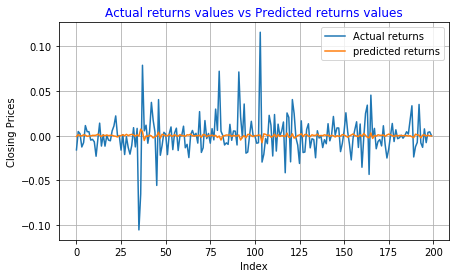

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(Santam_Test,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()

In [44]:
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(Santam_Test)):
    if Santam_Test[t-1]>=Santam_Test[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)

([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0], 200)
Predicted data:
([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,

(200, 200, list)

In [45]:
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
print("From a sample of",len(binary_test),"data points")

('The number of correct direction predictions is:', 136, 'out of:', 200, 'data points')
('From a sample of', 200, 'data points')


(68.0, '%')
[[69 27]
 [37 67]]


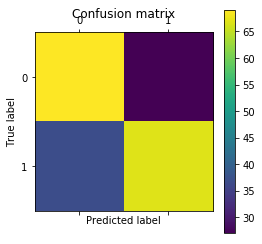

In [46]:
Confusion_matrix(len(Santam_Test))

$\textbf{Sanlam}$

Sanlam Limited is a South Africa-based holding company. The Company provides financial solutions to individuals and institutional clients through a network of channels and partnerships in approximately 50 countries. The Company operates through six segments: Sanlam Personal Finance, which is responsible for retail business in South Africa; Sanlam Emerging Markets, which includes general insurance and investment management; Sanlam Investments, which includes Investment Management and Capital Management; Sanlam Corporate, which includes Sanlam Employee Benefits and Sanlam Health Management; Santam, which provides a range of general insurance products and services, and Group office and Other. Its solutions include Life insurance, general insurance, investment management (including retail savings, asset management and wealth management), credit and structuring, and administration health and other (such as estate planning, trusts, wills, and lending and health management). 

In [47]:
#load the data set
filename = 'slm.csv'
SanlamTS = pd.read_csv(filename,na_filter=True,index_col="Date").dropna()
SanlamTS.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
13/01/02,4520.0,4550,4509,4545,2035263
13/01/03,4550.0,4558,4516,4549,1488016
13/01/04,4512.0,4600,4512,4598,1498258
13/01/07,4600.0,4640,4568,4609,1705254
13/01/08,4625.0,4631,4601,4631,1989724


In [48]:
print"The sample contains:", len(SanlamTS),"observations"

The sample contains: 1177 observations


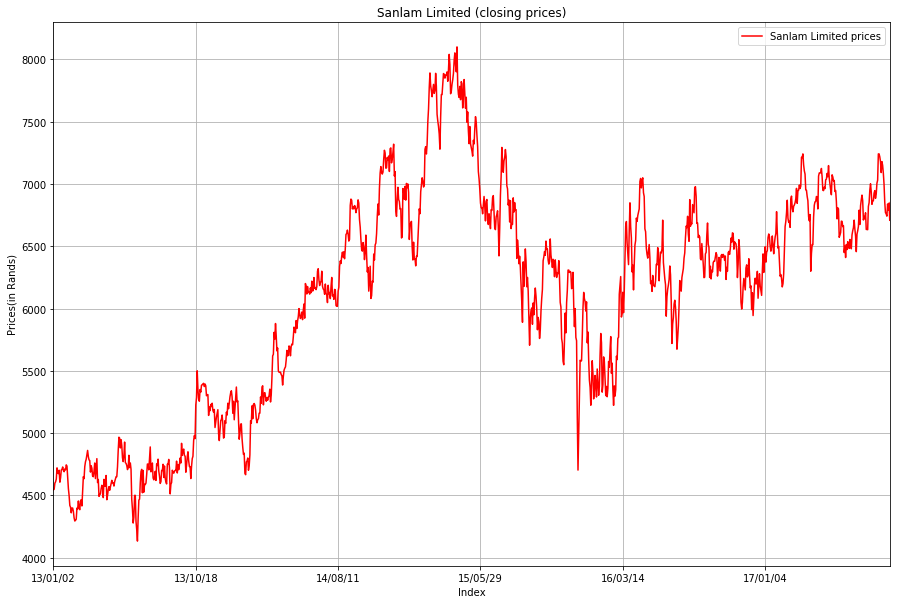

In [49]:
plt.figure(figsize=(15,10))
SanlamTS["Close"].plot(label="Sanlam Limited prices",color="red")
plt.grid(True)
plt.title("Sanlam Limited (closing prices)",color="black")
plt.xlabel("Index")
plt.ylabel("Prices(in Rands)")
plt.legend(loc=1)

In [50]:
#The log-returns
returns=np.log((SanlamTS["Close"])/(SanlamTS["Close"].shift()))
returns.head(5)
returns=returns.dropna()

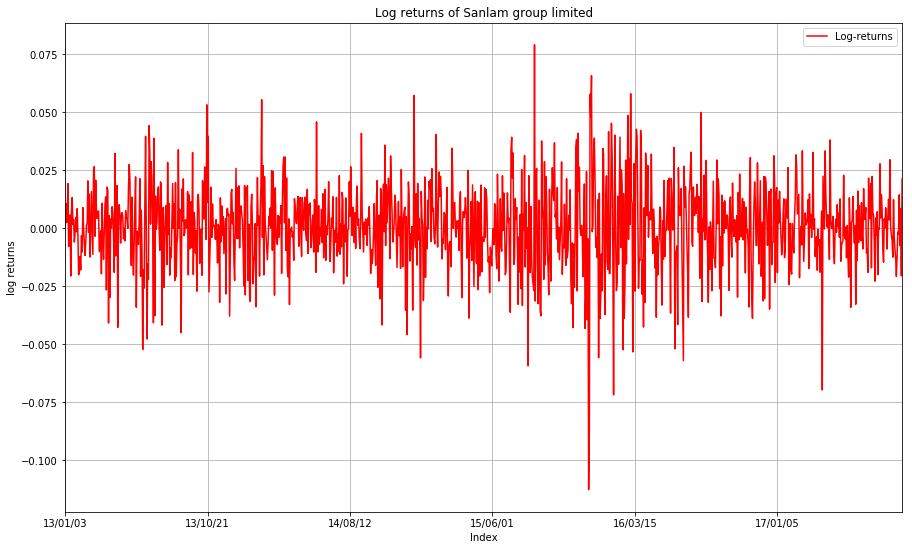

In [51]:
plt.figure(figsize=(15,9))
returns.plot(label="Log-returns",color="red")
plt.grid(True)
plt.title("Log returns of Sanlam group limited",color="black")
plt.xlabel("Index")
plt.ylabel("log returns")
plt.legend(loc=0)
plt.show()

### split1 Train: 500 Test :200

In [52]:
SanlamTrain=returns[0:500]
SanlamTest=returns[500:700]

In [53]:
import statsmodels.tsa.api as smt
import pymc as mc

# Priors
prior_phi = mc.Uniform('phi', -1, 1)
prior_theta = mc.Uniform('theta', -1, 1)
prior_precision = mc.Gamma('precision', 2, 4)

# Create the model for likelihood evaluation
model = smt.SARIMAX(SanlamTrain,order=(1, 0, 1))

# Create the "data" component (stochastic and observed)
@mc.stochastic(dtype=smt.statespace.MLEModel, observed=True)
def loglikelihood(value=model, phi=prior_phi, theta=prior_theta, precision=prior_precision):
    return value.loglike([phi, theta, 1/precision])

# Create the PyMC model
pymc_model = mc.Model((prior_phi, prior_theta, prior_precision, loglikelihood))

# Create a PyMC sample and perform sampling
sampler = mc.MCMC(pymc_model)
sampler.sample(iter=20000, burn=3000, thin=10)

 [-----------------100%-----------------] 20000 of 20000 complete in 66.4 sec

Plotting theta
Plotting precision
Plotting phi


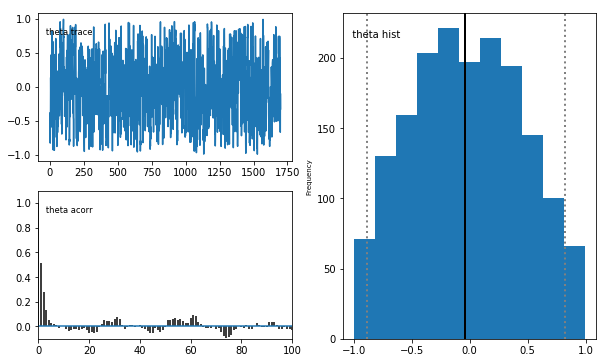

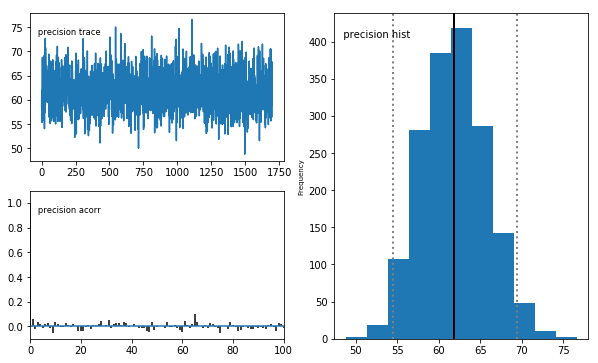

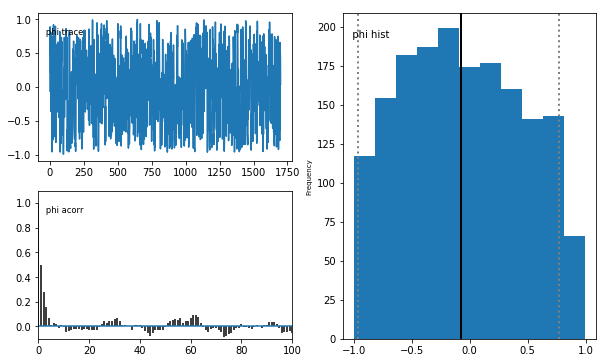

In [54]:
# Plot traces for the individual parameters
warnings.filterwarnings("ignore") 
mc.Matplot.plot(sampler)
plt.show()

In [55]:
sampler.summary()


theta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.022           0.472            0.019            [-0.88   0.825]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.864           -0.383          -0.036         0.345         0.857
	

precision:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	61.847           3.898            0.098          [ 54.453  69.41 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	54.597           59.017          61.846         64.414        69.724
	

phi:
 
	Mean             SD               MC Error        95% HPD interval
	------------------

In [56]:
#make predictions from the fitted modeL
#We use the retrieved coefficients from the fitted model to make predictions
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as smt
from math import sqrt
SanlamTrain=np.array(SanlamTrain)   
SanlamTest=np.array(SanlamTest) 
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat
import numpy as np
ar_params=prior_phi.stats()['mean']
ar_params=np.array([ar_params])
ma_params=prior_theta.stats()['mean']
ma_params=np.array([ma_params]) 
history = [x for x in SanlamTrain]
test_predicted = list()
for t in range(len(SanlamTest)):
    model_fit = model.fit(trend='nc', disp=False)
    ar_coef, ma_coef = ar_params, ma_params
    resid = model_fit.resid
    yhat = predict(ar_coef, history) + predict(ma_coef, resid)
    test_predicted.append(yhat)
    obs = SanlamTest[t]
    history.append(obs)
    print('predicted=%.5f, expected=%.5f' % (yhat, obs))

predicted=0.00420, expected=0.01589
predicted=0.00040, expected=0.00449
predicted=0.00100, expected=0.00149
predicted=0.00116, expected=-0.03123
predicted=0.00289, expected=-0.01614
predicted=0.00209, expected=0.02213
predicted=0.00007, expected=-0.02119
predicted=0.00236, expected=0.00047
predicted=0.00121, expected=-0.00879
predicted=0.00171, expected=0.01207
predicted=0.00060, expected=-0.00031
predicted=0.00126, expected=0.02021
predicted=0.00017, expected=0.01681
predicted=0.00035, expected=0.02095
predicted=0.00013, expected=-0.00575
predicted=0.00154, expected=0.02569
predicted=-0.00012, expected=0.00747
predicted=0.00084, expected=0.00855
predicted=0.00079, expected=-0.00384
predicted=0.00144, expected=-0.00671
predicted=0.00159, expected=0.00200
predicted=0.00113, expected=0.04051
predicted=-0.00091, expected=0.00288
predicted=0.00109, expected=-0.00812
predicted=0.00167, expected=0.01085
predicted=0.00066, expected=0.02429
predicted=-0.00005, expected=0.01364
predicted=0.0005

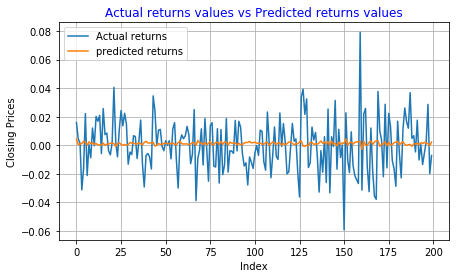

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(SanlamTest,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()

In [58]:
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(SanlamTest)):
    if SanlamTest[t-1]>=SanlamTest[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
print("From a sample of",len(binary_test),"data points")

([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1], 200)
Predicted data:
([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,

(68.5, '%')
[[68 39]
 [24 69]]


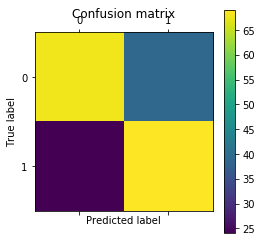

In [59]:
Confusion_matrix(len(SanlamTest))

### split2 Train: 700 Test :200

In [60]:
SanlamTrain=returns[0:700]
SanlamTest=returns[700:900]

 [-----------------100%-----------------] 20000 of 20000 complete in 74.9 secPlotting precision
Plotting phi
Plotting theta


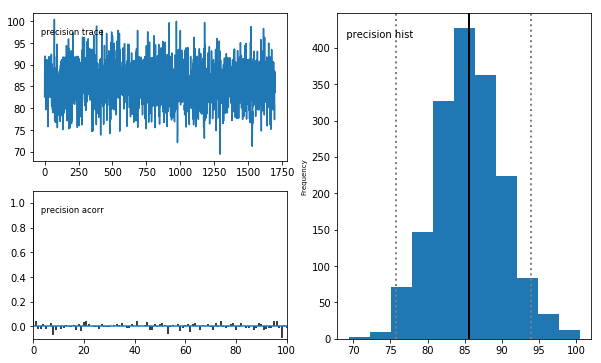

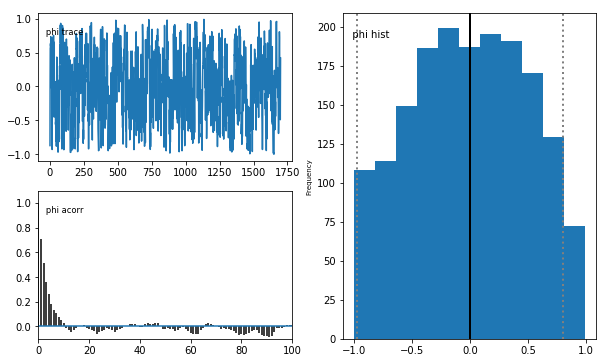

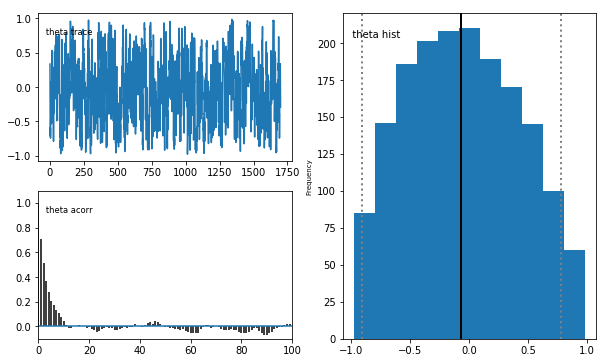


precision:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	85.565           4.575            0.104          [ 75.73   93.959]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	76.467           82.51           85.529         88.588        94.989
	

phi:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.01            0.502            0.027            [-0.975  0.8  ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.929           -0.407          -0.006         0.405         0.872
	

theta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------

In [61]:
import statsmodels.tsa.api as smt
import pymc as mc

# Priors
prior_phi = mc.Uniform('phi', -1, 1)
prior_theta = mc.Uniform('theta', -1, 1)
prior_precision = mc.Gamma('precision', 2, 4)

# Create the model for likelihood evaluation
model = smt.SARIMAX(SanlamTrain,order=(1, 0, 1))

# Create the "data" component (stochastic and observed)
@mc.stochastic(dtype=smt.statespace.MLEModel, observed=True)
def loglikelihood(value=model, phi=prior_phi, theta=prior_theta, precision=prior_precision):
    return value.loglike([phi, theta, 1/precision])

# Create the PyMC model
pymc_model = mc.Model((prior_phi, prior_theta, prior_precision, loglikelihood))

# Create a PyMC sample and perform sampling
sampler = mc.MCMC(pymc_model)
sampler.sample(iter=20000, burn=3000, thin=10)
# Plot traces for the individual parameters
warnings.filterwarnings("ignore") 
mc.Matplot.plot(sampler)
plt.show()
sampler.summary()

In [62]:
#make predictions from the fitted modeL
#We use the retrieved coefficients from the fitted model to make predictions
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as smt
from math import sqrt
SanlamTrain=np.array(SanlamTrain)   
SanlamTest=np.array(SanlamTest) 
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat
import numpy as np
ar_params=prior_phi.stats()['mean']
ar_params=np.array([ar_params])
ma_params=prior_theta.stats()['mean']
ma_params=np.array([ma_params]) 
history = [x for x in SanlamTrain]
test_predicted = list()
for t in range(len(SanlamTest)):
    model_fit = model.fit(trend='nc', disp=False)
    ar_coef, ma_coef = ar_params, ma_params
    resid = model_fit.resid
    yhat = predict(ar_coef, history) + predict(ma_coef, resid)
    test_predicted.append(yhat)
    obs = SanlamTest[t]
    history.append(obs)
    print('predicted=%.5f, expected=%.5f' % (yhat, obs))

predicted=0.00050, expected=-0.00849
predicted=0.00052, expected=0.01037
predicted=0.00034, expected=-0.00612
predicted=0.00049, expected=-0.01602
predicted=0.00059, expected=0.02135
predicted=0.00023, expected=-0.01276
predicted=0.00056, expected=-0.00955
predicted=0.00053, expected=0.00558
predicted=0.00038, expected=-0.00080
predicted=0.00044, expected=0.01658
predicted=0.00028, expected=-0.02137
predicted=0.00064, expected=-0.03252
predicted=0.00074, expected=-0.00630
predicted=0.00049, expected=-0.04282
predicted=0.00084, expected=-0.00679
predicted=0.00050, expected=-0.02549
predicted=0.00068, expected=-0.00503
predicted=0.00048, expected=0.03384
predicted=0.00011, expected=0.03828
predicted=0.00007, expected=-0.02702
predicted=0.00069, expected=0.04101
predicted=0.00005, expected=0.01591
predicted=0.00028, expected=0.02634
predicted=0.00018, expected=0.00000
predicted=0.00043, expected=-0.00302
predicted=0.00046, expected=0.00127
predicted=0.00042, expected=-0.00127
predicted=0.

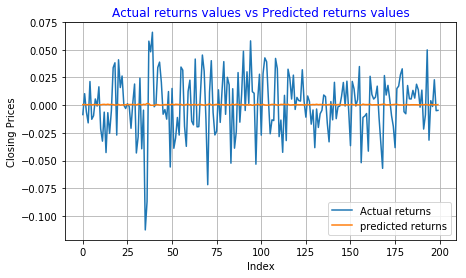

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(SanlamTest,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()

([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1], 200)
Predicted data:
([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,

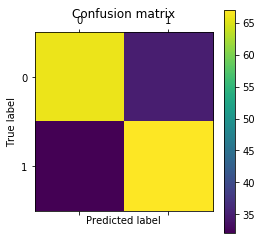

In [64]:
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(SanlamTest)):
    if SanlamTest[t-1]>=SanlamTest[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
print("From a sample of",len(binary_test),"data points")
Confusion_matrix(len(SanlamTest))

# Nedbank
is one of the largest banks in South Africa; however, it is one of the newest banks to be incorporated. It is headquartered in Johannesburg. Market capitalization was ZAR:120 billion (approximately US$9.85 billion), as of 30 June 2015.

In [65]:
#load the data 
filename = 'ned.csv'
nedbankTS = pd.read_csv(filename,na_filter=True,index_col="Date").dropna()
nedbankTS.head(5)


,Open,High,Low,Close,Volume
Date,,,,,
13/01/02,18888,19001,18755,18975,292269
13/01/03,19000,19001,18741,18947,182826
13/01/04,19000,19000,18750,18832,191315
13/01/07,19079,19184,18818,19025,296281
13/01/08,19010,19159,18806,18977,241453


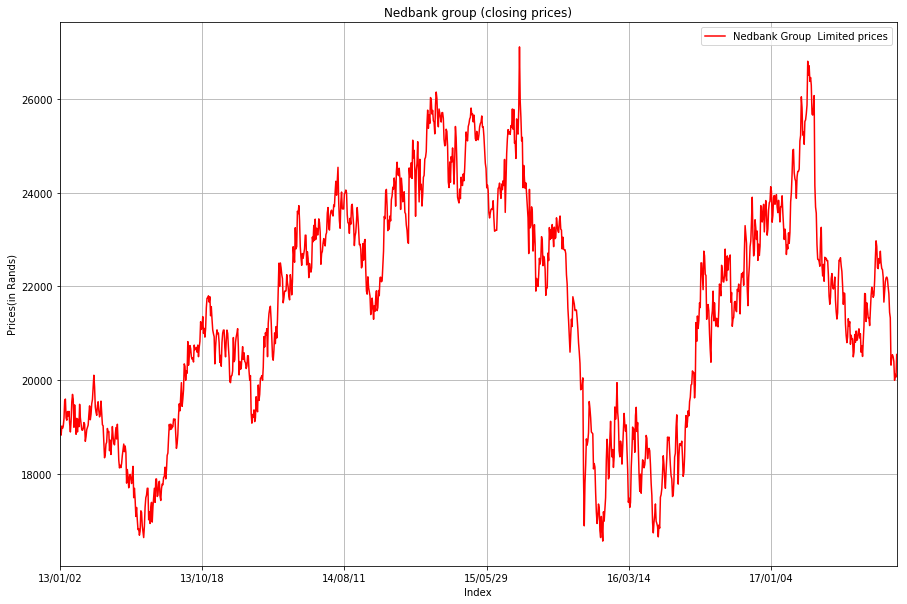

In [66]:
plt.figure(figsize=(15,10))
nedbankTS["Close"].plot(label="Nedbank Group  Limited prices",color="red")
plt.grid(True)
plt.title("Nedbank group (closing prices)",color="black")
plt.xlabel("Index")
plt.ylabel("Prices(in Rands)")
plt.legend(loc=1)

In [67]:
#The log-returns
returns=np.log((nedbankTS["Close"])/(nedbankTS["Close"].shift()))
returns.head(5)
returns=returns.dropna()

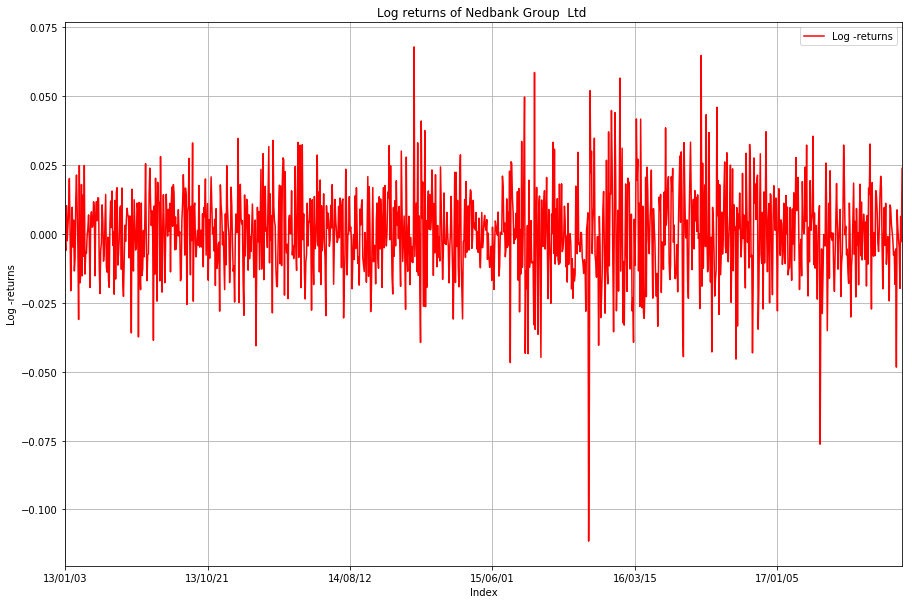

In [68]:
plt.figure(figsize=(15,10))
returns.plot(label="Log -returns",color="red")
plt.grid(True)
plt.title("Log returns of Nedbank Group  Ltd ",color="black")
plt.xlabel("Index")
plt.ylabel("Log -returns")
plt.legend(loc=1)

### split1 Train: 500 Test :200

In [69]:
nedbankTrain=returns[0:500]
nedbankTest=returns[500:700]

 [-----------------100%-----------------] 20000 of 20000 complete in 68.7 secPlotting precision
Plotting theta
Plotting phi


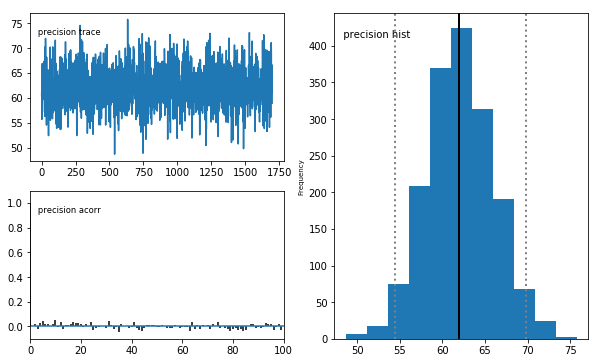

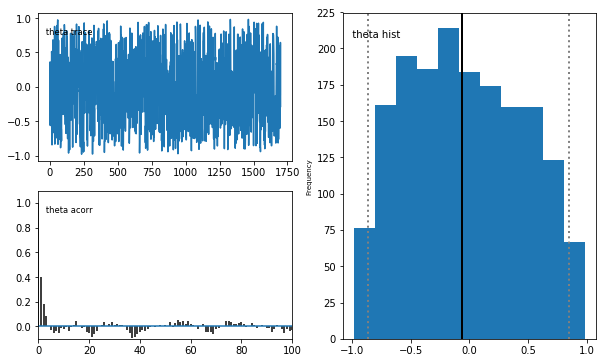

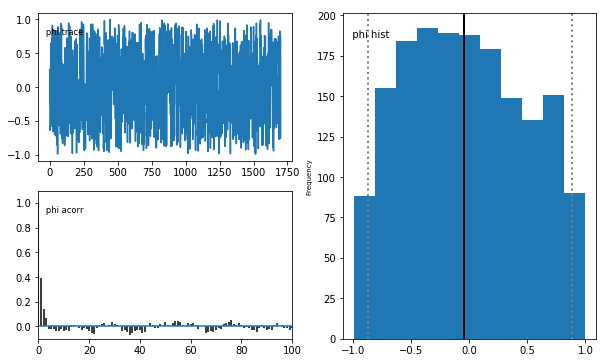


precision:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	62.058           3.918            0.103          [ 54.387  69.782]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	54.517           59.505          61.945         64.635        69.98
	

theta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.039           0.493            0.017            [-0.865  0.85 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.858           -0.451          -0.064         0.366         0.871
	

phi:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [70]:
import statsmodels.tsa.api as smt
import pymc as mc

# Priors
prior_phi = mc.Uniform('phi', -1, 1)
prior_theta = mc.Uniform('theta', -1, 1)
prior_precision = mc.Gamma('precision', 2, 4)

# Create the model for likelihood evaluation
model = smt.SARIMAX(nedbankTrain,order=(1, 0, 1))

# Create the "data" component (stochastic and observed)
@mc.stochastic(dtype=smt.statespace.MLEModel, observed=True)
def loglikelihood(value=model, phi=prior_phi, theta=prior_theta, precision=prior_precision):
    return value.loglike([phi, theta, 1/precision])

# Create the PyMC model
pymc_model = mc.Model((prior_phi, prior_theta, prior_precision, loglikelihood))

# Create a PyMC sample and perform sampling
sampler = mc.MCMC(pymc_model)
sampler.sample(iter=20000, burn=3000, thin=10)
# Plot traces for the individual parameters
warnings.filterwarnings("ignore") 
mc.Matplot.plot(sampler)
plt.show()
sampler.summary()


In [71]:
#make predictions from the fitted modeL
#We use the retrieved coefficients from the fitted model to make predictions
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as smt
from math import sqrt
nedbankTrain=np.array(nedbankTrain)
nedbankTest=np.array(nedbankTest)
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat
import numpy as np
ar_params=prior_phi.stats()['mean']
ar_params=np.array([ar_params])
ma_params=prior_theta.stats()['mean']
ma_params=np.array([ma_params]) 
history = [x for x in nedbankTrain]
test_predicted = list()
for t in range(len(nedbankTest)):
    model_fit = model.fit(trend='nc', disp=False)
    ar_coef, ma_coef = ar_params, ma_params
    resid = model_fit.resid
    yhat = predict(ar_coef, history) + predict(ma_coef, resid)
    test_predicted.append(yhat)
    obs = nedbankTest[t]
    history.append(obs)
    print('predicted=%.5f, expected=%.5f' % (yhat, obs))

predicted=0.00257, expected=0.04091
predicted=0.00058, expected=0.00574
predicted=0.00145, expected=0.01875
predicted=0.00113, expected=-0.02626
predicted=0.00224, expected=-0.02625
predicted=0.00224, expected=0.03744
predicted=0.00067, expected=-0.02645
predicted=0.00225, expected=0.00469
predicted=0.00148, expected=-0.01938
predicted=0.00207, expected=0.00999
predicted=0.00135, expected=0.01554
predicted=0.00121, expected=0.00168
predicted=0.00155, expected=0.01422
predicted=0.00124, expected=0.00142
predicted=0.00156, expected=0.00500
predicted=0.00147, expected=0.02317
predicted=0.00102, expected=0.01164
predicted=0.00131, expected=-0.01510
predicted=0.00197, expected=0.01094
predicted=0.00132, expected=-0.00689
predicted=0.00177, expected=0.02140
predicted=0.00106, expected=-0.00162
predicted=0.00163, expected=-0.01196
predicted=0.00189, expected=0.00303
predicted=0.00152, expected=-0.00858
predicted=0.00181, expected=-0.00118
predicted=0.00162, expected=-0.00985
predicted=0.00184

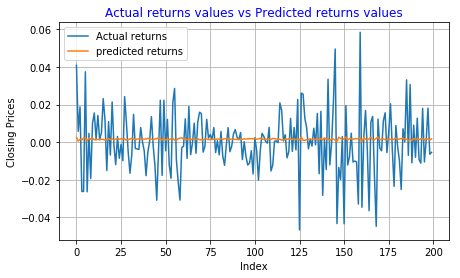

In [72]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(nedbankTest,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()

([1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1], 200)
Predicted data:
([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,

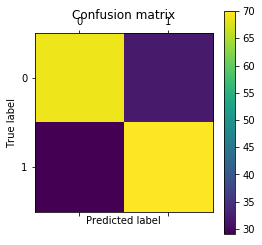

In [73]:
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(nedbankTest)):
    if nedbankTest[t-1]>=nedbankTest[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
print("From a sample of",len(binary_test),"data points")
Confusion_matrix(len(nedbankTest))

### split2 Train:700 Test:200

In [74]:
nedbankTrain=returns[0:700]
nedbankTest=returns[700:900]

 [-----------------100%-----------------] 20000 of 20000 complete in 73.2 secPlotting precision
Plotting theta
Plotting phi


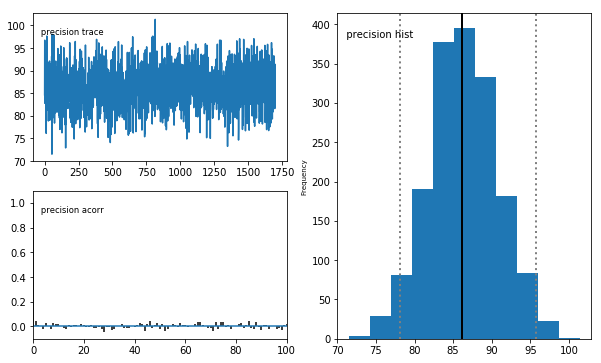

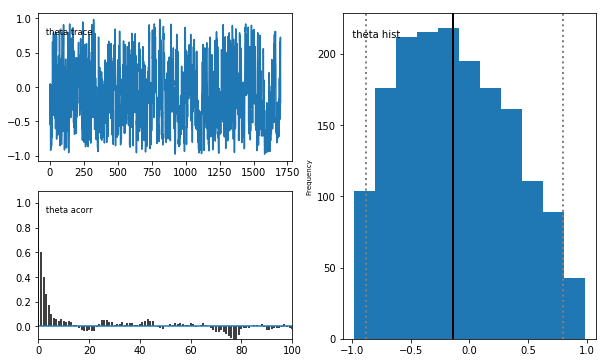

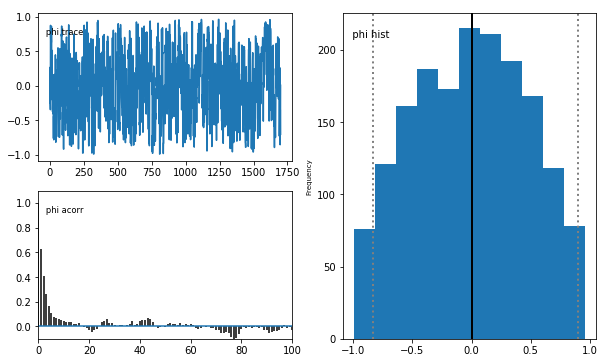


precision:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	86.29            4.425            0.118          [ 78.181  95.677]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	77.489           83.239          86.193         89.317        95.084
	

theta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.114           0.474            0.024            [-0.877  0.801]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.875           -0.509          -0.139         0.252         0.808
	

phi:
 
	Mean             SD               MC Error        95% HPD interval
	------------------

In [75]:
import statsmodels.tsa.api as smt
import pymc as mc

# Priors
prior_phi = mc.Uniform('phi', -1, 1)
prior_theta = mc.Uniform('theta', -1, 1)
prior_precision = mc.Gamma('precision', 2, 4)

# Create the model for likelihood evaluation
model = smt.SARIMAX(nedbankTrain,order=(1, 0, 1))

# Create the "data" component (stochastic and observed)
@mc.stochastic(dtype=smt.statespace.MLEModel, observed=True)
def loglikelihood(value=model, phi=prior_phi, theta=prior_theta, precision=prior_precision):
    return value.loglike([phi, theta, 1/precision])

# Create the PyMC model
pymc_model = mc.Model((prior_phi, prior_theta, prior_precision, loglikelihood))

# Create a PyMC sample and perform sampling
sampler = mc.MCMC(pymc_model)
sampler.sample(iter=20000, burn=3000, thin=10)
# Plot traces for the individual parameters
warnings.filterwarnings("ignore") 
mc.Matplot.plot(sampler)
plt.show()
sampler.summary()




In [76]:
#make predictions from the fitted modeL
#We use the retrieved coefficients from the fitted model to make predictions
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as smt
from math import sqrt
nedbankTrain=np.array(nedbankTrain)
nedbankTest=np.array(nedbankTest) 
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat
import numpy as np
ar_params=prior_phi.stats()['mean']
ar_params=np.array([ar_params])
ma_params=prior_theta.stats()['mean']
ma_params=np.array([ma_params]) 
history = [x for x in nedbankTrain]
test_predicted = list()
for t in range(len(nedbankTest)):
    model_fit = model.fit(trend='nc', disp=False)
    ar_coef, ma_coef = ar_params, ma_params
    resid = model_fit.resid
    yhat = predict(ar_coef, history) + predict(ma_coef, resid)
    test_predicted.append(yhat)
    obs = nedbankTest[t]
    history.append(obs)
    print('predicted=%.5f, expected=%.5f' % (yhat, obs))

predicted=0.00059, expected=-0.00147
predicted=0.00056, expected=0.01001
predicted=0.00046, expected=0.00499
predicted=0.00050, expected=-0.01199
predicted=0.00065, expected=-0.00086
predicted=0.00055, expected=-0.01752
predicted=0.00069, expected=0.01099
predicted=0.00045, expected=-0.01113
predicted=0.00064, expected=-0.00061
predicted=0.00055, expected=0.00004
predicted=0.00055, expected=-0.00356
predicted=0.00058, expected=-0.02002
predicted=0.00071, expected=-0.00903
predicted=0.00062, expected=-0.02340
predicted=0.00074, expected=-0.01276
predicted=0.00065, expected=-0.01712
predicted=0.00069, expected=-0.01475
predicted=0.00067, expected=0.01728
predicted=0.00040, expected=0.01614
predicted=0.00041, expected=-0.00726
predicted=0.00061, expected=0.02954
predicted=0.00030, expected=-0.00386
predicted=0.00058, expected=-0.00328
predicted=0.00057, expected=-0.00650
predicted=0.00060, expected=0.00051
predicted=0.00054, expected=0.00005
predicted=0.00055, expected=-0.00841
predicted=

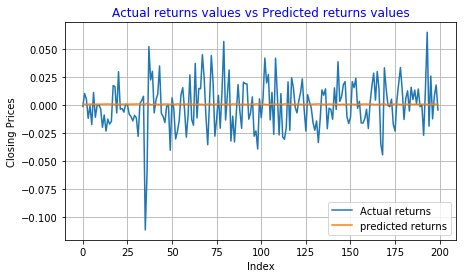

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(nedbankTest,label="Actual returns")
plt.plot(test_predicted,label="predicted returns")
plt.grid(True)
plt.title("Actual returns values vs Predicted returns values",color="blue")
plt.xlabel("Index")
plt.ylabel("Closing Prices")
plt.legend(loc=0)
plt.show()

([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0], 200)
Predicted data:
([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,

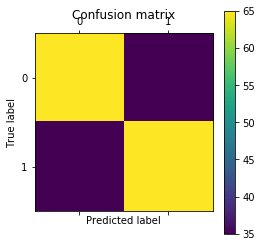

In [78]:
binary_predicted_test=[]
for t in range(0,len(test_predicted)):
    if test_predicted[t-1]>=test_predicted[t]:
        binary_predicted_test.append(0)
    else:
        binary_predicted_test.append(1)
print(binary_predicted_test,len(binary_predicted_test))

print("Predicted data:")
#convert normalised (testing)data to binary 0 or 1
binary_test=[]
for t in range(0,len(nedbankTest)):
    if nedbankTest[t-1]>=nedbankTest[t]:
        binary_test.append(0)
    else:
        binary_test.append(1)
print(binary_test,len(binary_test))
len(binary_test),len(binary_predicted_test),type(binary_test)
#we count the number of correct predictions, if i-j==0 then we predicted the direction correclty
def counter(x,y):
    count=0   
    for (i,j) in zip(x,y):
        if i-j==0:
            count=count+1
    print ("The number of correct direction predictions is:",count,"out of:",len(x),"data points")
counter(binary_test,binary_predicted_test)
print("From a sample of",len(binary_test),"data points")
Confusion_matrix(len(nedbankTest))

# Accuracy for ARMA(1,1)-metropolis Hastings : 
# Train:500 Test:200, Train:700 Test:200

In [3]:
import pandas as pd    
steps=[[68.5,65.5],[69,68],[68.5,66.5],[69.5,65]]        

In [4]:
data=pd.DataFrame(steps,index=['Netcare','Santam','Sanlam','Nedbank'],columns=["Train:500 Test:200","Train:700 Test:200"])

In [5]:
data

,Train:500 Test:200,Train:700 Test:200
Netcare,68.5,65.5
Santam,69.0,68.0
Sanlam,68.5,66.5
Nedbank,69.5,65.0


### Summary results of ARMA(1,1)-metropolis Hastings  Train:500 Test:200

Summary results of ARMA(1,1)-Metropolis Hastings model Train:500 Test:200


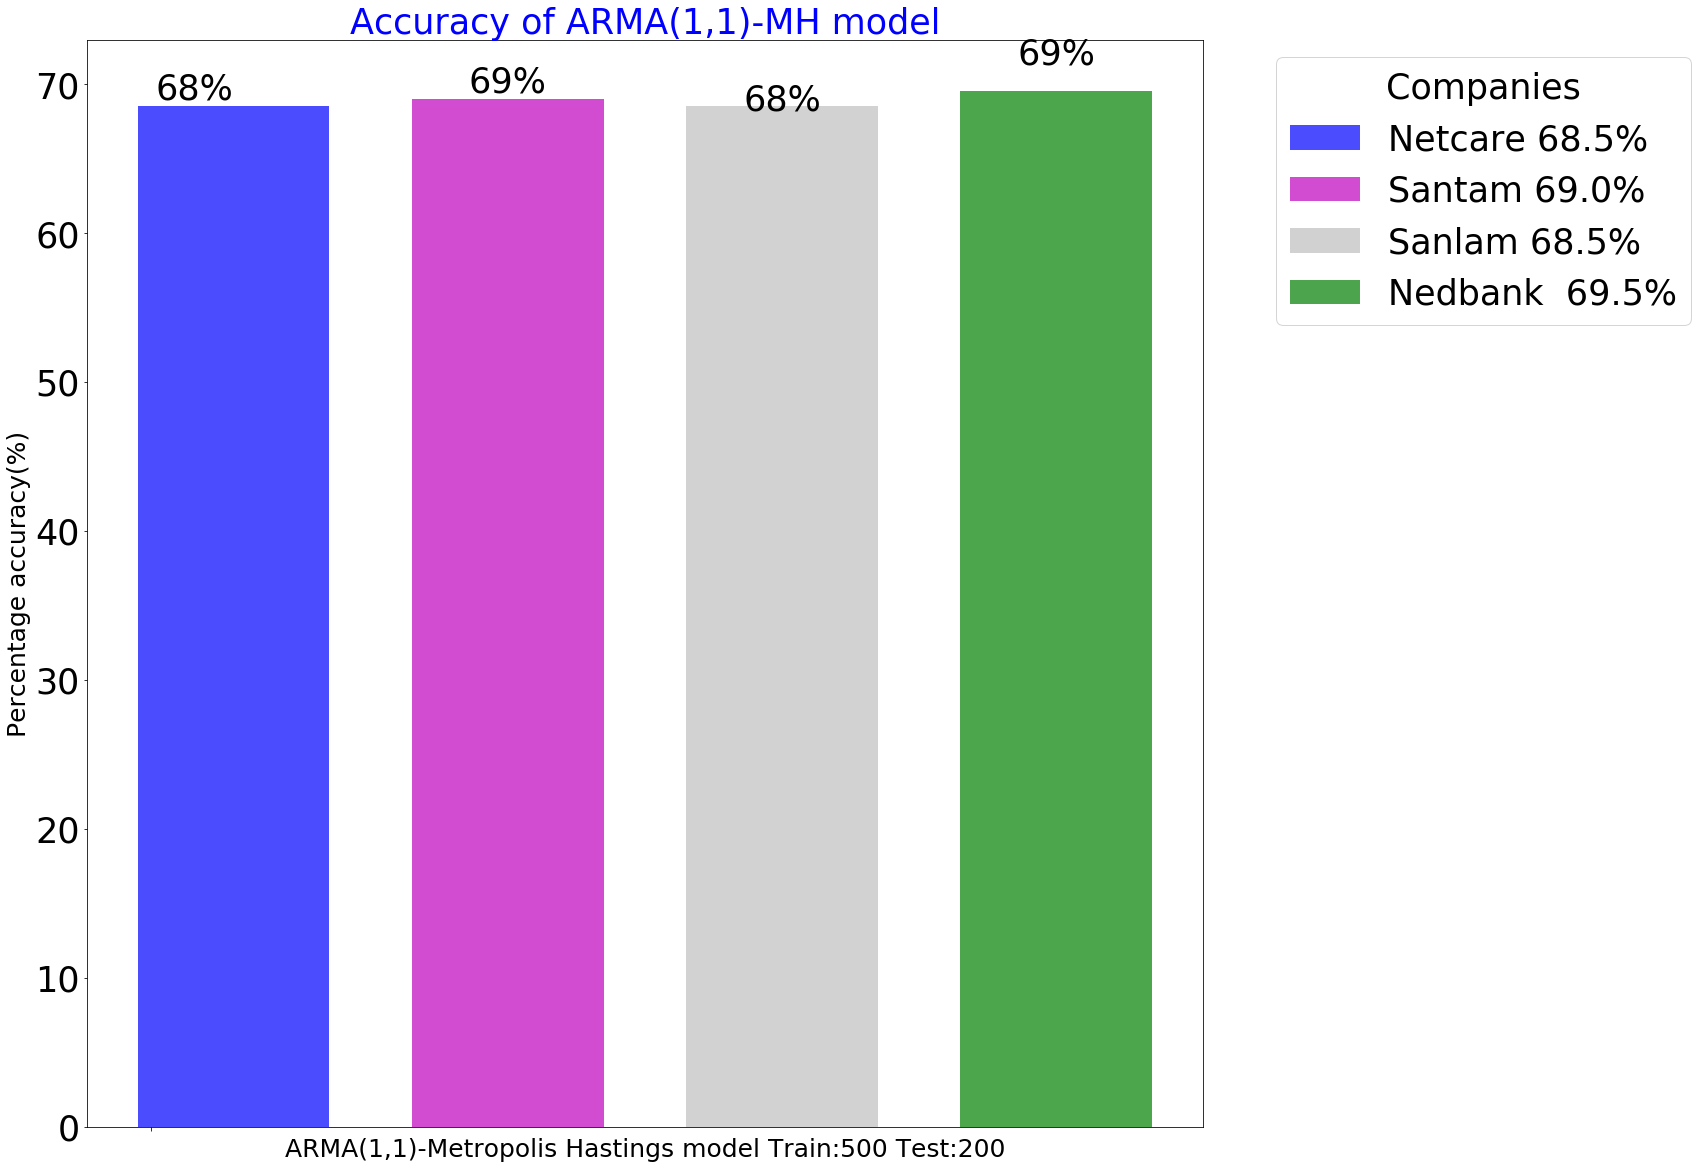

In [7]:
import numpy as np

# data to plot
n_groups = 1

Netcare=(68.5)
Santam=(69.0)
Sanlam=(68.5)
Nedbank = (69.5)
#AR_A_GARCH=(71)


# Create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.07
opacity =0.7

rects1 = plt.bar(0.1, Netcare, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Netcare 68.5%')
 
rects2 = plt.bar(0.2, Santam, bar_width,
                 alpha=opacity,
                 color='m',
                 label='Santam 69.0%')
rects3 = plt.bar(0.3, Sanlam, bar_width,
                 alpha=opacity,
                 color="0.75",
                 label='Sanlam 68.5%')
rects4 = plt.bar(0.4, Nedbank, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Nedbank  69.5%')

rects=[rects1,rects2,rects3,rects4]

#Display the accuray as percentage
for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
            '%d' % int(height) + "%", ha='right', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
            '%d' % int(height) + "%", ha='center', va='bottom')
for rect in rects3:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 0.99*height,
            '%d' % int(height) + "%", ha='center', va='bottom')

for rect in rects4:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
            '%d' % int(height) + "%", ha='center', va='bottom')
    

    
#Size of the graph
print("Summary results of ARMA(1,1)-Metropolis Hastings model Train:500 Test:200")
import matplotlib.pylab as plt
from pylab import rcParams
plt.rcParams['figure.figsize'] = 20,20   
plt.rc('font', size=35)  
plt.rc('axes', labelsize=35)
plt.xlabel('ARMA(1,1)-Metropolis Hastings model Train:500 Test:200',fontsize= 25)
plt.ylabel('Percentage accuracy(%)',fontsize= 25)
plt.title('Accuracy of ARMA(1,1)-MH model',color="blue",fontsize= 35)
plt.xticks(index + bar_width, ('', ''))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5,fontsize= 35,title="Companies") 
#plt.tight_layout()
plt.show()
    

### Summary results of ARMA(1,1)-metropolis Hastings  Train:700 Test:200

Summary results of ARMA(1,1)-Metropolis Hastings model Train:700 Test:200


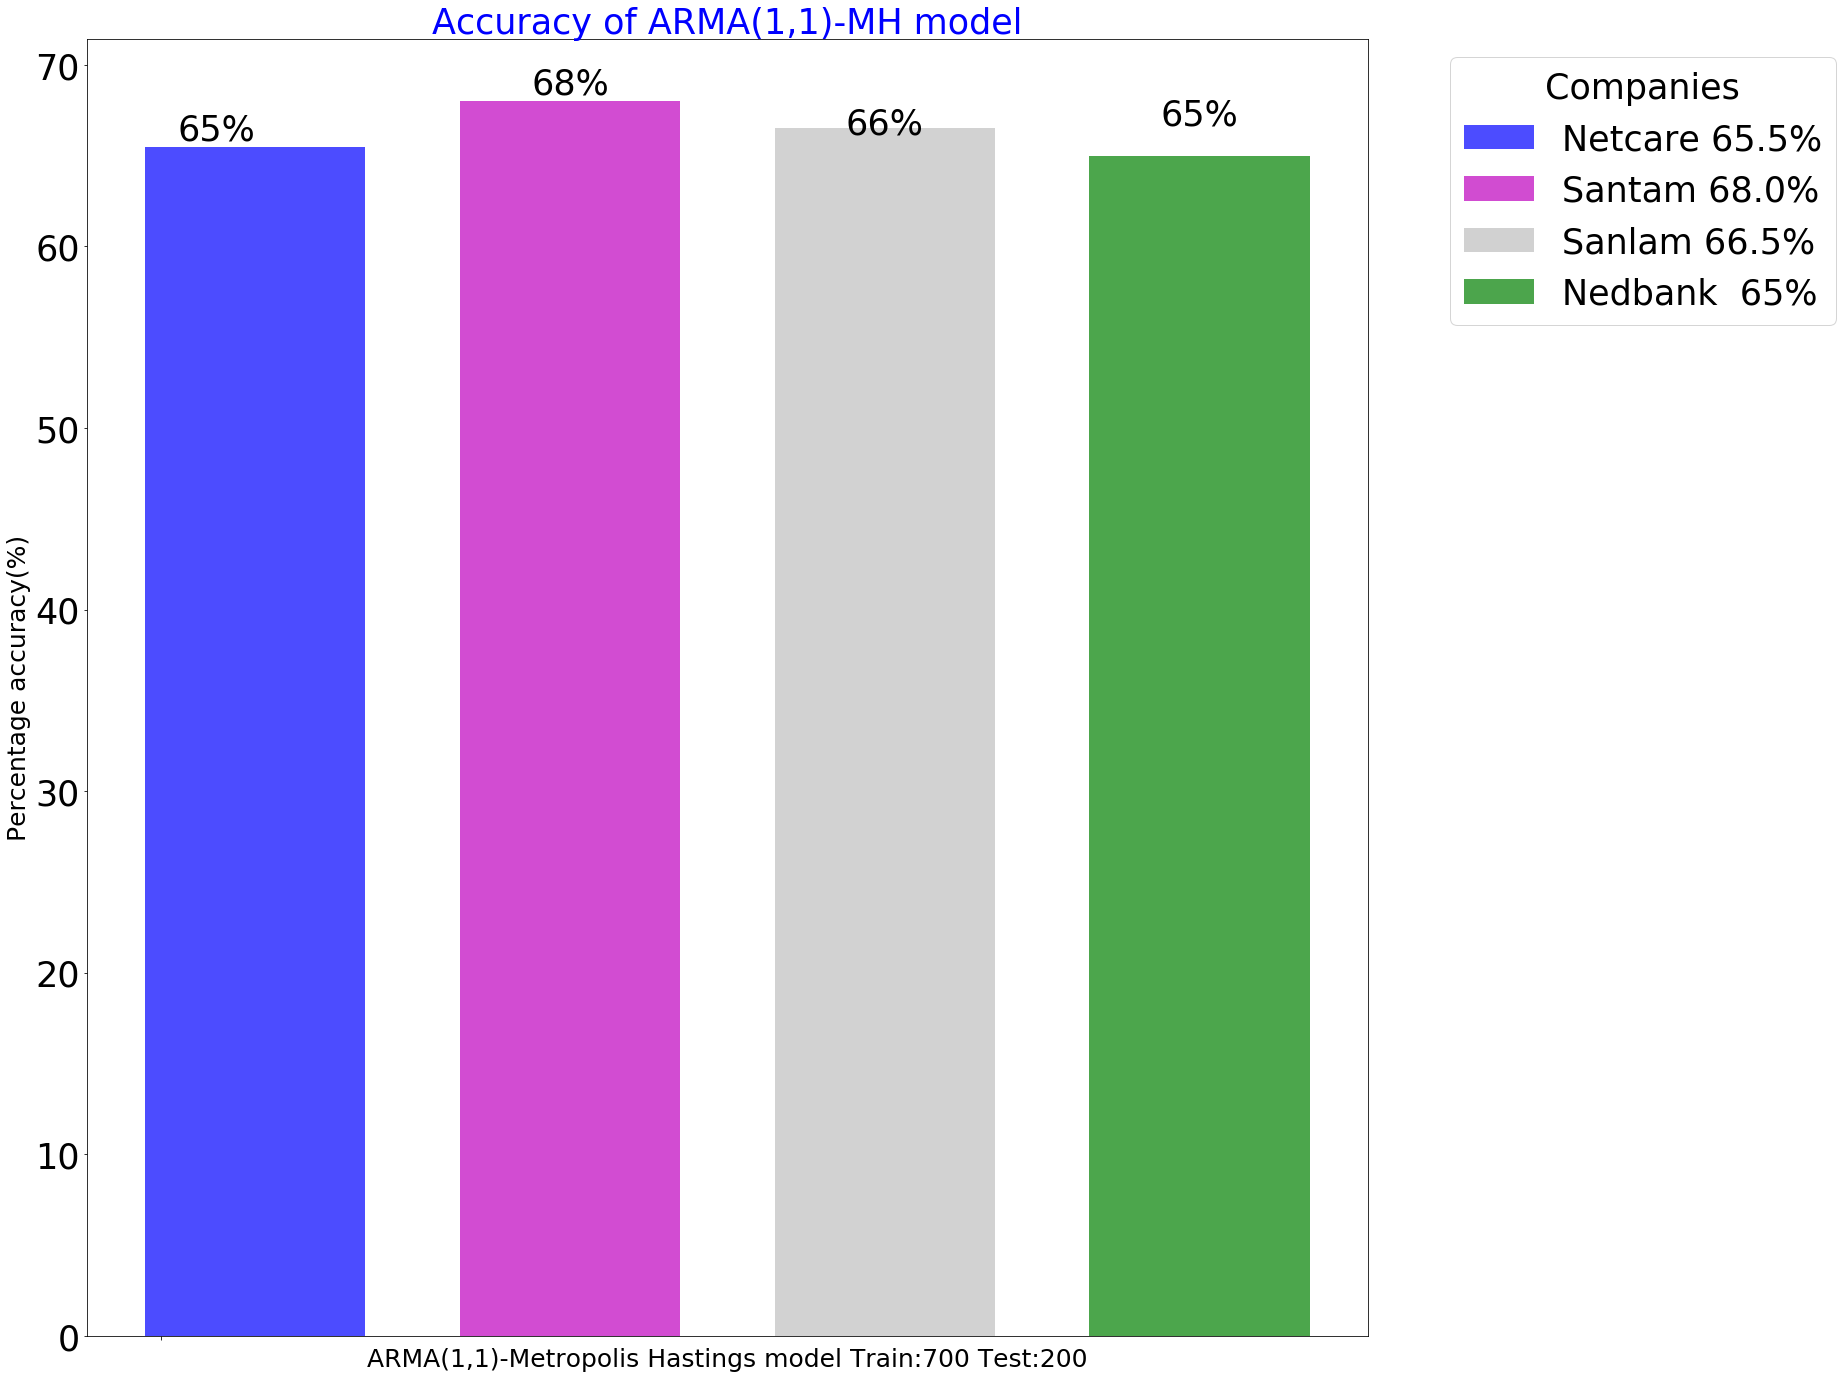

In [8]:
# data to plot
n_groups = 1

Netcare=(65.5)
Santam=(68.0)
Sanlam=(66.5)
Nedbank = (65)
#AR_A_GARCH=(71)


# Create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.07
opacity =0.7

rects1 = plt.bar(0.1, Netcare, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Netcare 65.5%')
 
rects2 = plt.bar(0.2, Santam, bar_width,
                 alpha=opacity,
                 color='m',
                 label='Santam 68.0%')
rects3 = plt.bar(0.3, Sanlam, bar_width,
                 alpha=opacity,
                 color="0.75",
                 label='Sanlam 66.5%')
rects4 = plt.bar(0.4, Nedbank, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Nedbank  65%')

rects=[rects1,rects2,rects3,rects4]

#Display the accuray as percentage
for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
            '%d' % int(height) + "%", ha='right', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height,
            '%d' % int(height) + "%", ha='center', va='bottom')
for rect in rects3:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 0.99*height,
            '%d' % int(height) + "%", ha='center', va='bottom')

for rect in rects4:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
            '%d' % int(height) + "%", ha='center', va='bottom')
    

    
#Size of the graph
print("Summary results of ARMA(1,1)-Metropolis Hastings model Train:700 Test:200")
import matplotlib.pylab as plt
from pylab import rcParams
plt.rcParams['figure.figsize'] = 20,20   
plt.rc('font', size=35)  
plt.rc('axes', labelsize=35)
plt.xlabel('ARMA(1,1)-Metropolis Hastings model Train:700 Test:200',fontsize= 25)
plt.ylabel('Percentage accuracy(%)',fontsize= 25)
plt.title('Accuracy of ARMA(1,1)-MH model',color="blue",fontsize= 35)
plt.xticks(index + bar_width, ('', ''))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5,fontsize= 35,title="Companies") 
plt.tight_layout()
plt.show()
    

Source: (a) http://www.chadfulton.com/topics/state_space_mh.html (b) https://machinelearningmastery.com/make-manual-predictions-arima-models-python/